In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

In [2]:
train=pd.read_csv(r'train.csv')
test=pd.read_csv(r'test.csv')
sample_submission=pd.read_csv(r'sample_submission.csv')

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

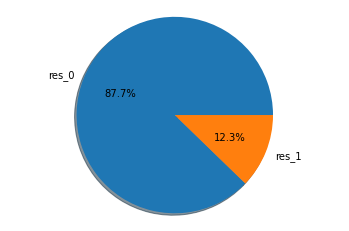

In [5]:
fig1, ax1 = plt.subplots()
labels=['Response_1','Response_0']
ax1.pie(train['Response'].value_counts(),labels=['res_0','res_1'],autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

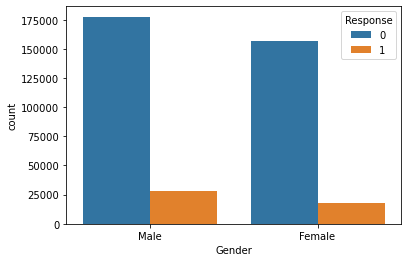

In [6]:
sns.countplot("Gender",hue='Response',data=train)

In [7]:
train['Gender']=train['Gender'].replace(['Male','Female'],[2,1])
test['Gender']=test['Gender'].replace(['Male','Female'],[2,1])

In [8]:
train.Vehicle_Age.value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [9]:
train['Vehicle_Age']=train['Vehicle_Age'].replace(['< 1 Year','1-2 Year','> 2 Years'],[1,2,3])
test['Vehicle_Age']=test['Vehicle_Age'].replace(['< 1 Year','1-2 Year','> 2 Years'],[1,2,3])

In [10]:
train['Vehicle_Damage']=train['Vehicle_Damage'].replace(['Yes','No'],[2,1])
test['Vehicle_Damage']=test['Vehicle_Damage'].replace(['Yes','No'],[2,1])

In [11]:
y=train.Response
x=train.drop(columns=['Response'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [13]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

Using TensorFlow backend.


In [31]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators =100,max_depth=7, min_samples_split=5)
classifier.fit(X_train,y_train)
pred1=classifier.predict(X_test)
print(confusion_matrix(y_test, pred1))
print(accuracy_score(y_test,pred1))

TypeError: __init__() got an unexpected keyword argument 'scale_pos_weight'

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimator=500,learning_rate=0.1,scale_pos_weight=6)
xgb_model.fit(X_train_res,y_train_res)
pred1=xgb_model.predict(X_test)
print(confusion_matrix(y_test, pred1))
print(accuracy_score(y_test,pred1))

[20:20:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [26]:
from lightgbm import LGBMClassifier
lgb= LGBMClassifier(n_estimators=300,learning_rate=0.1,scale_pos_weight=6)
lgb.fit(X_train_res,y_train_res)
pred1=lgb.predict(X_test)
print(confusion_matrix(y_test, pred1))
print(accuracy_score(y_test,pred1))

[[32919 17076]
 [  496  6676]]
0.6926198681057253


In [18]:
from sklearn.ensemble import VotingClassifier
estimator = [('classifier',classifier),('xgb_model',xgb_model),('lgb',lgb)]
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train,y_train)
pred1=lgb.predict(X_test)
print(confusion_matrix(y_test, pred1))
print(accuracy_score(y_test,pred1))

[20:01:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[[49927    68]
 [ 7106    66]]
0.8745080203613973


In [33]:
#submission file by lgb classifer
pred=xgb_model.predict(test)
pred_sub=pd.DataFrame(pred,columns=['Response'])
final_data=pd.DataFrame(pd.concat([sample_submission['id'],pred_sub],axis=1))
final_data.to_csv(r'submission.csv',index=False)